In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Расположение файлов**

In [3]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

**Загрузка данных**

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

**Анализ данных**

In [5]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [11]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.102962


В основном у нас количественные переменные

In [12]:
df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

но есть и несколько качественных

In [6]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [8]:
df.isna().sum().sort_values(ascending=False)

Healthcare_1     4798
LifeSquare       2113
Id                  0
Ecology_3           0
Shops_2             0
Shops_1             0
Helthcare_2         0
Social_3            0
Social_2            0
Social_1            0
Ecology_2           0
DistrictId          0
Ecology_1           0
HouseYear           0
HouseFloor          0
Floor               0
KitchenSquare       0
Square              0
Rooms               0
Price               0
dtype: int64

Видно наличие пропусков в двух переменных: Healthcare_1 и LifeSquare. Необходимо будет заполнить пропуски средними значениями. 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

У переменных Rooms и HouseFloor тип float64, хотя логичнее было бы int64

Посмотрим как рапределяются значения в переменных Rooms и HouseYear, где видны слишком низкие и высокие крайние значения.

In [20]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Видно наличие квартир с количеством комнат 0. Вероятно, имеются ввиду квартиры-студии. Также видно наличие квартир с большим количеством комнат, но их очень мало - можно расценивать это как выбросы. Нужно их заменить на значение моды - 2.0.   

In [21]:
df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1910           1
1916           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

Видны два неверных значения года постройки. Необходимо будет их исправить.

**Предобработка данных**

Приведем типы данных двух переменных к int64:

In [24]:
df['Rooms'] = df['Rooms'].astype('int64')
df['HouseFloor'] = df['HouseFloor'].astype('int64')

Исправим значения в переменных Rooms и HouseYear:

In [25]:
df.loc[df['Rooms'] == 0, 'Rooms'] = 1
df.loc[df['Rooms'] > 5 , 'Rooms'] = 2
df.loc[df['HouseYear'] == 4968 , 'HouseYear'] = 1968
df.loc[df['HouseYear'] == 20052011 , 'HouseYear'] = 2011

Заполняем пропущенные значения в переменных LifeSquare и Healthcare_1:

In [27]:
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()

Заменяем в категориальных переменных строковые значения на цифры 1 и 0:

In [29]:
new_map = {"B": 1, "A": 0,}
df["Ecology_2"] = df["Ecology_2"].map(new_map)
df["Ecology_3"] = df["Ecology_3"].map(new_map)
df["Shops_2"] = df["Shops_2"].map(new_map)


Оформляем всю предобработку в отдельную функцию:

In [6]:
def data_processing(df):
    df['Rooms'] = df['Rooms'].astype('int64')
    df['HouseFloor'] = df['HouseFloor'].astype('int64')
    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    df.loc[df['Rooms'] > 5 , 'Rooms'] = 2
    df.loc[df['HouseYear'] == 4968 , 'HouseYear'] = 1968
    df.loc[df['HouseYear'] == 20052011 , 'HouseYear'] = 2011
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
    new_map = {"B": 1, "A": 0,}
    df["Ecology_2"] = df["Ecology_2"].map(new_map)
    df["Ecology_3"] = df["Ecology_3"].map(new_map)
    df["Shops_2"] = df["Shops_2"].map(new_map)
    return df
    
    
    

In [7]:
t = pd.read_csv(TRAIN_DATASET_PATH)

In [9]:
t_new = data_processing(t)

In [10]:
t_new.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3,115.027311,32.781260,10.0,4,10,2014,0.075424,1,1,11,3097,0,900.0,0,0,1,305018.871089
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850
3,2352,1,1,40.409907,32.781260,1.0,10,22,1977,0.007122,1,1,1,264,0,900.0,0,1,1,168106.007630
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,1,1,33,8667,2,900.0,0,6,1,343995.102962


**Построение модели RandomForestRegressor**

In [31]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [32]:
X = df[[ 'Rooms', 'Square',  'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2']]
y = df['Price']    

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [33]:
forest = RandomForestRegressor(criterion='mse', n_jobs= -1)
forest.fit(x_train, y_train)

RandomForestRegressor(criterion='mse', n_jobs=-1)

Train R2:	0.961
Test R2:	0.713


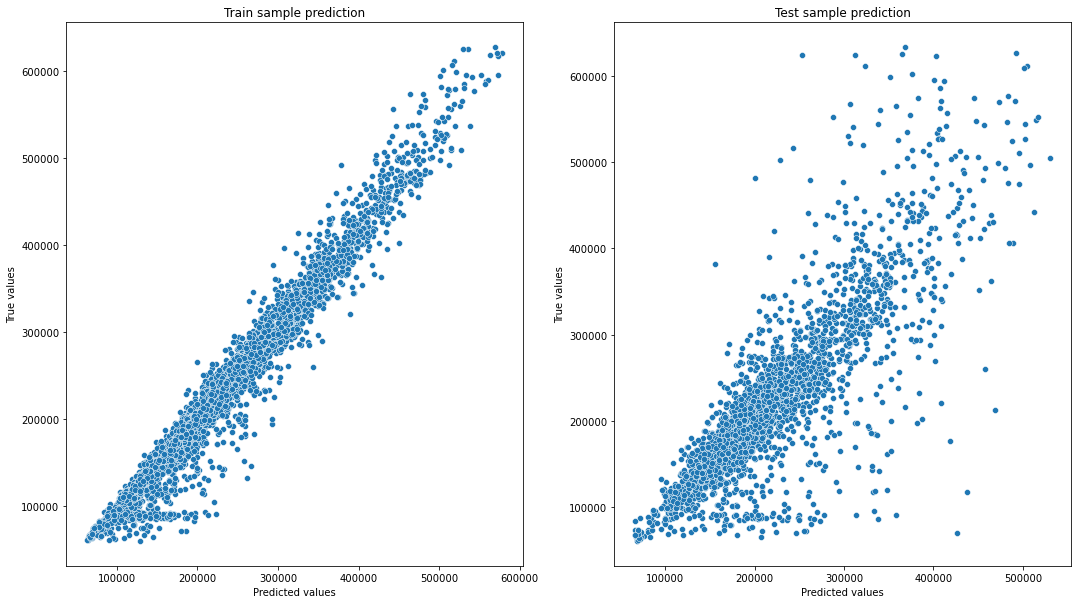

In [34]:
train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

Модель неплохо работает на тренировочных данных, разбитых на train и test выборки.

**Оформление итогового предсказания**

Загружаем тренировочные и тестовые данные:

In [15]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

Обрабатываем данные, обучаем модель:

In [16]:
train = data_processing(train)
test = data_processing(test)

In [17]:
features = [ 'Rooms', 'Square',  'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2']
target = ['Price']

X = train[features]
y = train[target]  

In [18]:
forest = RandomForestRegressor(criterion='mse', n_jobs= -1)
forest.fit(X, y)

RandomForestRegressor(criterion='mse', n_jobs=-1)

Делаем финальное предсказание с тестовыми данными и сохраняем в файл:

In [19]:
itog_test = test[features]
itog_test = itog_test.fillna(0)
pred = pd.DataFrame(forest.predict(itog_test), columns=['pred'])
pred

,pred
0,153145.174412
1,118836.557740
2,141629.252716
3,108504.466298
4,208938.404407
...,...
4995,179948.313072
4996,393323.353077
4997,145472.878482
4998,189020.072808


In [21]:
pred.to_csv('KonstDziadziulia_predictions.csv', index=None)